#Importing the libraries and setting up the notebook

In [1]:
import fastbook
import os
from fastbook import *
from fastai.vision.widgets import *

#Collecting Imagery Data using Microsoft Azure

In [2]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [3]:
dog_types = ['german shepherd', 'black', 'labrador']
path = Path('dogs')

if not path.exists():
    path.mkdir()
    for t in dog_types:
        dest = (path/t)
        print(dest)
        dest.mkdir(exist_ok=True)
        results = search_images_bing('016d4856b8c74099b65871ba7668b870', '{} dog'.format(t), 128, 1)
        print(results)
        download_images(dest, urls=results.attrgot('contentUrl'))

files = get_image_files(path)
files

corrupt = verify_images(files)
corrupt

corrupt.map(Path.unlink)

/usr/local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#0) []

#Converting downloaded data into DataLoader objects

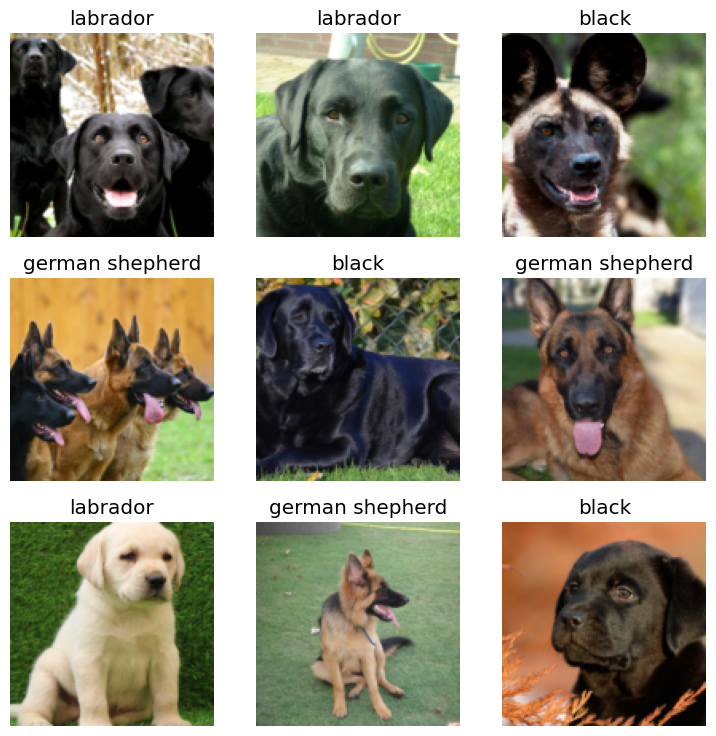

In [4]:
dogs = DataBlock(
                  blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=41),
                  get_y=parent_label,
                  item_tfms=Resize(128)
                  )
dls = dogs.dataloaders(path)
dls.valid.show_batch()

##Data transformations

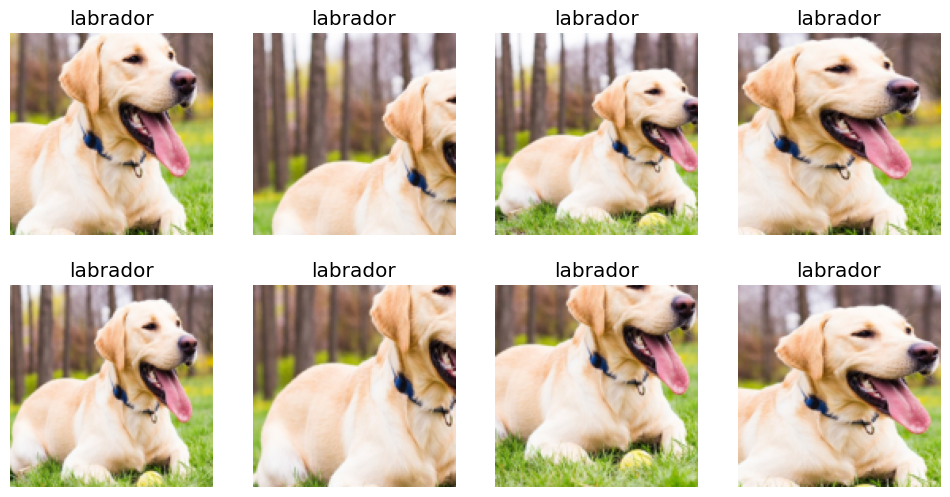

In [5]:

dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#Data augmentation

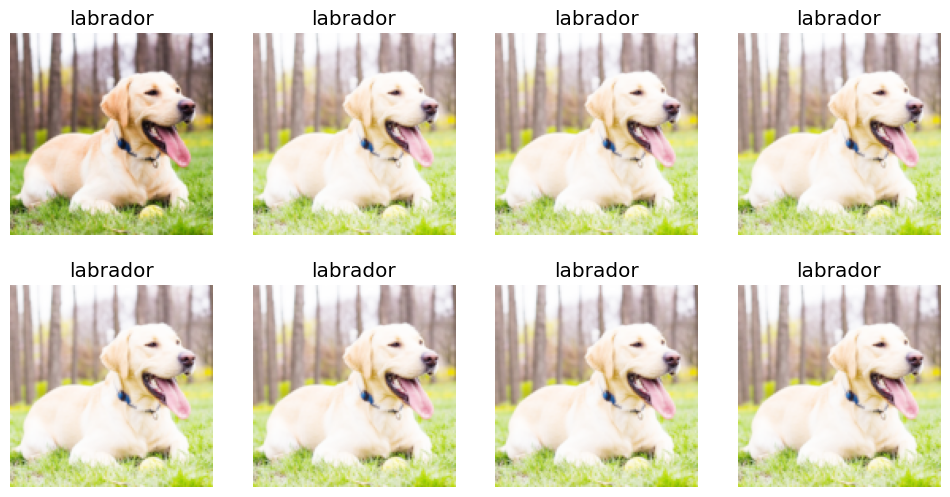

In [6]:
dogs = dogs.new(item_tfms=[Resize(128)], batch_tfms=[Brightness(max_lighting = 0.3, p = 0.4)])
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#Model Training and Data Cleaning

In [7]:
model = vision_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(4)

/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/usr/local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


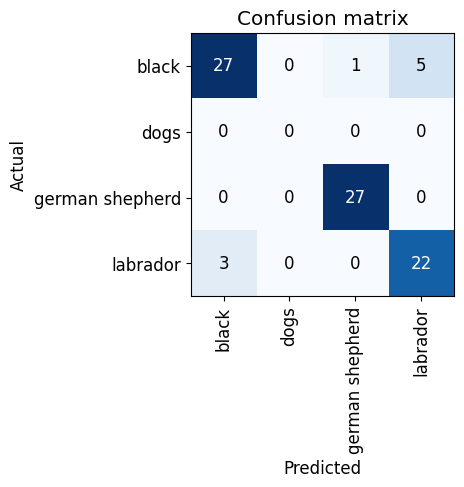

In [8]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

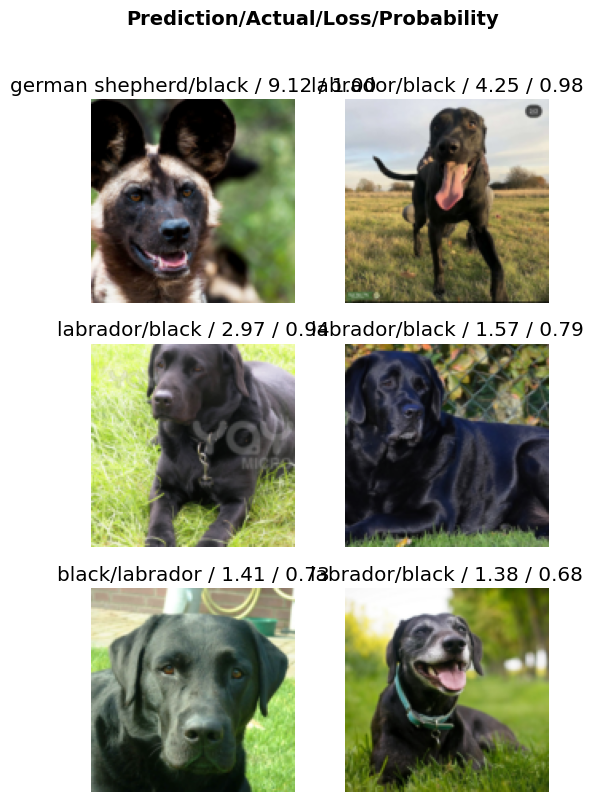

In [9]:
interp.plot_top_losses(6, nrows=3)

#Cleaning the data

In [10]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [11]:
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), str(path/cat)+"/"+str(cleaner.fns[idx]).split("/")[-1].split(".")[0]+"_fixed.jpg")

#Export the Trained Model

In [12]:
model.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [13]:
model_inf = load_learner(path/'export.pkl')

In [14]:
model_inf.predict('dogs/0.jpeg')

('german shepherd',
 TensorBase(2),
 TensorBase([4.8760e-06, 2.1820e-02, 9.7817e-01, 1.0645e-07]))

#Add widgets to upload and classify images

In [15]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [16]:
VBox([widgets.Label('Select your dog'), btn_upload, btn_run, out_pl, lbl_pred])